# Evaluating the Climate sensitivity of HR- and LR-CESM

In [1]:
import os
import sys
import numpy as np
import xarray as xr
import cmocean
import cartopy
import scipy.stats as stats
import cartopy.crs as ccrs
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
mpl.rc_file('../rc_file')
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append("..")
from tqdm import notebook
from paths import path_results, path_prace, CESM_filename, file_ex_atm_lpd
from filters import lowpass
from constants import spy, sigma
from constants import R_earth
from xr_regression import xr_linear_trend, xr_lintrend
from matplotlib.patches import Rectangle
from longrunmip_estimations import do_estimations
A_Earth = 4*np.pi*R_earth**2

## ECS estimate overview figure

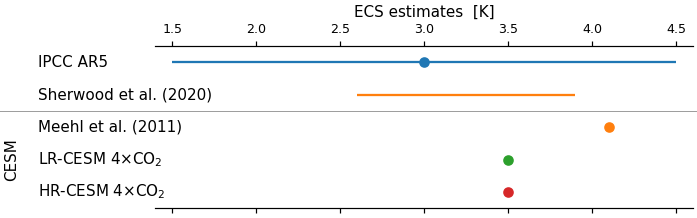

In [4]:
plt.figure(figsize=(6.4,2))
x = .7
plt.text(x,  0, 'IPCC AR5'                , va='center')
plt.text(x, -1, 'Sherwood et al. (2020)'  , va='center')
plt.text(x, -2, 'Meehl et al. (2011)'     , va='center')
plt.text(x, -3, r'LR-CESM 4$\times$CO$_2$', va='center')
plt.text(x, -4, r'HR-CESM 4$\times$CO$_2$', va='center')
plt.text(.5,-3, 'CESM', rotation=90, va='center')
plt.plot([x-1,5],[-1.5,-1.5], c='grey', lw=.5, clip_on = False)
plt.scatter(3, 0)
plt.errorbar(3, 0, xerr=1.5)
plt.errorbar(3.25, -1, xerr=1.3/2)
plt.scatter(4.1, -2)
plt.scatter(3.5, -3)
plt.scatter(3.5, -4)
plt.yticks([])
plt.xlabel('ECS estimates  [K]')
plt.xlim((1.4,4.6))
plt.ylim((-4.5,.5))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().xaxis.set_label_position('top')
plt.gca().tick_params(axis="x", bottom=True, top=True, labelbottom=False, labeltop=True)
# plt.gca().spines['top'].set_visible(False)

## ECS estimates from CESM

In [5]:
# load data, creation cell at end of this notebook
dhq = xr.open_dataset('../../results/ECS/ECS_estimates_HR-CESM.nc')
dlq = xr.open_dataset('../../results/ECS/ECS_estimates_LR-CESM.nc')
dmq = xr.open_dataset('../../results/ECS/ECS_estimates_LongRunMIP.nc')

CPU times: user 32.1 ms, sys: 7.76 ms, total: 39.8 ms
Wall time: 146 ms


## CESM ECS/TCR ; Gregory plot

In [7]:
6.76/2

3.38

hq l    = 1.27 W/m2/K     CS[:50]   = 6.58 degC     ECS[:50]   = 3.29 degC
hq l_20 = 1.07 W/m2/K     CS[20:50] = 7.02 degC     ECS[20:50] = 3.51 degC

lq l    = 1.19 W/m2/K     CS[:50]   = 6.81 degC     ECS[:50]   = 3.40 degC
lq l_20 = 0.87 W/m2/K     CS[20:50] = 7.64 degC     ECS[20:50] = 3.82 degC

lq l    = 1.19 W/m2/K     CS[:]     = 6.80 degC     ECS[:]     = 3.40 degC
lq l_20 = 1.15 W/m2/K     CS[20:]   = 6.89 degC     ECS[20:]   = 3.44 degC
mq l    = 1.44 W/m2/K     CS[:50]   = 5.27 degC     ECS[:50]   = 2.64 degC
mq l_20 = 1.25 W/m2/K     CS[20:50] = 5.51 degC     ECS[20:50] = 2.75 degC

mq l    = 0.72 W/m2/K     CS[:]     = 6.66 degC     ECS[:]     = 3.33 degC
mq l_20 = 0.68 W/m2/K     CS[20:]   = 6.68 degC     ECS[20:]   = 3.34 degC


/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/home

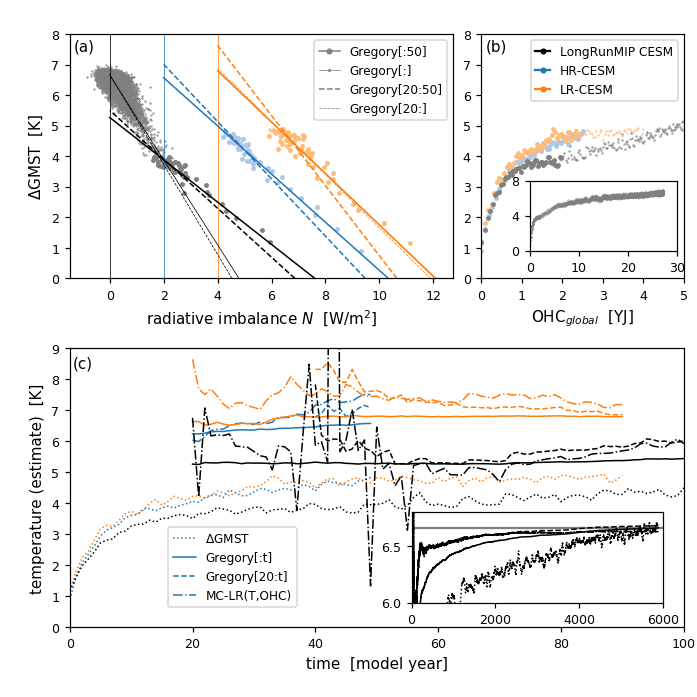

In [57]:
# ignoring firs 20 years fo estimates to remove spikes
lam, Delta, sq, p20 = r'$\lambda$', r'$\Delta$', r'$^2$', r'$_{20+}$'
ch,cl,cm = plt.get_cmap('tab20')(.075), plt.get_cmap('tab20')(.175), 'grey'

f = plt.figure(figsize=(6.4,6.4))
axs = f.add_axes([.1 ,.6 ,.55,.35])              # top left
axo = f.add_axes([.69,.6 ,.29 ,.35], sharey=axs)  # top right
axp = f.add_axes([.76,.64,.21,.1])              # inset top right
axt = f.add_axes([.1,.1,.88,.4])                 # bottom
# axi = f.add_axes([.6,.35,.36,.13])               # inset bottom
axi = f.add_axes([.59,.135,.36,.13])               # inset bottom

axs.set_ylabel(f'{Delta}GMST  [K]')
axs.set_xlabel(f'radiative imbalance $N$  [W/m{sq}]')
axo.set_xlabel(r'OHC$_{global}$  [YJ]')
axt.set_xlabel('time  [model year]')
axt.set_ylabel('temperature (estimate)  [K]')


for i, ax in enumerate([axs,axo, axt]):
    ax.text([0.01,0.02,0.005][i], .93, ['(a)','(b)','(c)'][i], transform=ax.transAxes)

# equilibrium temps
# axi.axhspan(6.73,6.8, color='lightgrey', alpha=.5)
# axt.add_patch(Rectangle((95, 6.73), 5, 0.07, facecolor='grey'))
axi.axhline(6.66, color='grey')

# OHC inset
axp.scatter((dmq['OHC'][:50]-dmq['OHC'][0])/1e24, dmq['T'][:50], color=cm, s=.5)
axp.scatter((dmq['OHC'][50:]-dmq['OHC'][0])/1e24, dmq['T'][50:], color=cm, s=.02)

# ECS plot legends
for i, x in enumerate([0,2,4]):
    axs.axvline(x, lw=.5, c=['k','C0','C1'][i])
    axo.plot([],[], c=['k','C0','C1'][i], marker='o', markersize=3, label=['LongRunMIP CESM', 'HR-CESM', 'LR-CESM'][i])
axo.legend(loc='upper right', handlelength=1.2, fontsize=8)
axs.plot([],[], c='grey', lw=1 , ls='-',  label='Gregory[:50]', marker='o', markersize=3)
axs.plot([],[], c='grey', lw=.5, ls='-',  label='Gregory[:]'  , marker='o', markersize=1)
axs.plot([],[], c='grey', lw=1 , ls='--', label='Gregory[20:50]')
axs.plot([],[], c='grey', lw=.5, ls='--', label='Gregory[20:]')
axs.axhline(0, c='k', lw=.5)
axs.legend(loc='upper right', fontsize=8, handlelength=1.7)
    

for i, run in enumerate(['hq','lq','mq']):
    c = ['C0','C1','k'][i]
    
    c1 = [ch,cl,cm][i]
    lw = [1,1,.5,1,.5][i]
    ds = [dhq, dlq, dmq][i]
    shift = [2,4,0][i] 
    
    # Gregory fit
    axs.scatter(ds['N'][:50]+shift, ds['T'][:50], color=c1, s=5, clip_on=False)
    m, b = np.polyfit(ds['T'][:50], ds['N'][:50], 1)
    axs.plot([b+shift,0+shift], [0, -b/m], c=c, lw=1, clip_on=False)
    print(f'{run} l    = {-m:3.2f} W/m2/K     CS[:50]   = {-b/m:3.2f} degC     ECS[:50]   = {-b/m/2:3.2f} degC')
    
    # Gregory 20+ fit
    m, b = np.polyfit(ds['T'][20:50], ds['N'][20:50], 1)
    axs.plot([b+shift,0+shift], [0, -b/m], c=c, lw=1, ls='--', clip_on=False)
    print(f'{run} l_20 = {-m:3.2f} W/m2/K     CS[20:50] = {-b/m:3.2f} degC     ECS[20:50] = {-b/m/2:3.2f} degC')
    print()
    
    axo.scatter((ds['OHC'][:50]-ds['OHC'][0])/1e24, ds['T'][:50], color=c1, s=5)
    
    if len(ds.time)>50:
        axs.scatter(ds['N'][50:]+shift, ds['T'][50:], color=c1, s=.2, clip_on=False)
        m, b = np.polyfit(ds['T'], ds['N'], 1)
        axs.plot([b+shift,0+shift], [0, -b/m], c=c, lw=.5, clip_on=False)
        print(f'{run} l    = {-m:3.2f} W/m2/K     CS[:]     = {-b/m:3.2f} degC     ECS[:]     = {-b/m/2:3.2f} degC')
        # Gregory 20+ fit
        m, b = np.polyfit(ds['T'][20:], ds['N'][20:], 1)
        axs.plot([b+shift,0+shift], [0, -b/m], c=c, lw=.5, ls='--', clip_on=False)
        print(f'{run} l_20 = {-m:3.2f} W/m2/K     CS[20:]   = {-b/m:3.2f} degC     ECS[20:]   = {-b/m/2:3.2f} degC')
    
        axo.scatter((ds['OHC'][50:]-ds['OHC'][0])/1e24, ds['T'][50:], color=c1, s=.2)
        
    # time dependent
    lss = [':','-','--','-.']
    for j, q in enumerate(['DT', 'G', 'G20', 'TOHC_T']):
        hide = [0,20,40,20][j]
#         hide = [0,15,35,15][j]
        label = [f'{Delta}GMST', 'Gregory[:t]', 'Gregory[20:t]', 'MC-LR(T,OHC)'][j]
        axt.plot(ds.time[hide:], ds[q][hide:], ls=lss[j], lw=1, c=c, label=[label,None,None][i])
        if run=='mq':# and q=='TOHC_T':  # inset full time series
            if q=='DT': x = ds[q].rolling(time=30, center=True).mean()
            else: x = ds[q]
            axi.plot(ds.time, x, ls=lss[j], lw=1, c=c)
    
axo.set_xlim((0,5))
axp.set_xlim((0,30))
axp.set_xticks(np.arange(0,31,10))
# axp.set_xticklabels([0,None,10,None,20,None,30])
axp.set_yticks(np.arange(0,9,4))
# axp.set_yticklabels([0,None,None,None,4,None,None,None,8])
axi.set_xlim((0,6000))
axi.set_xticks(np.arange(0,6001,2000))
axi.set_ylim((6,6.8))
axs.set_ylim((0,8))
axt.set_ylim((0,9))
axt.set_xlim((0,100))

axt.legend(loc='lower left', bbox_to_anchor=(0.15,0.05), handlelength=1.9, ncol=1, fontsize=8, )
# axt.legend(loc='lower left', bbox_to_anchor=(0,0.5), handlelength=1.2, ncol=1, fontsize=8, )
plt.savefig(f'../../results/thesis/62_ECS_estimates.eps')

hq l    = 1.27 W/m2/K     ECS    = 3.29 degC
hq l_20 = 1.07 W/m2/K     ECS_20 = 3.51 degC
lq l    = 1.19 W/m2/K     ECS    = 3.40 degC
lq l_20 = 0.87 W/m2/K     ECS_20 = 3.82 degC
lq l    = 1.19 W/m2/K     ECS    = 3.40 degC
lq l_20 = 1.15 W/m2/K     ECS_20 = 3.44 degC
mq l    = 1.44 W/m2/K     ECS    = 2.64 degC
mq l_20 = 1.25 W/m2/K     ECS_20 = 2.75 degC
mq l    = 0.72 W/m2/K     ECS    = 3.33 degC
mq l_20 = 0.68 W/m2/K     ECS_20 = 3.34 degC


/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/ipykernel_launcher.py:98: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The Po

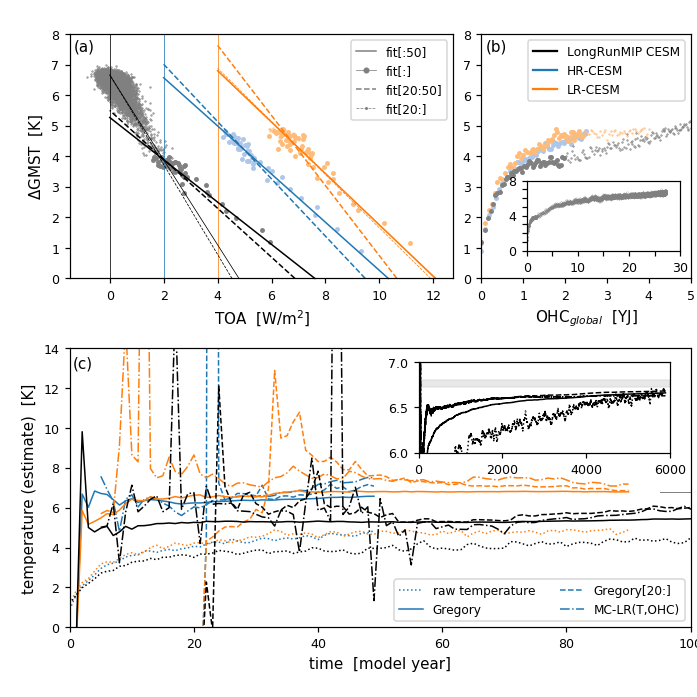

In [10]:
lam, Delta, sq, p20 = r'$\lambda$', r'$\Delta$', r'$^2$', r'$_{20+}$'
f = plt.figure(figsize=(6.4,6.4))
axs = f.add_axes([.1 ,.6 ,.55,.35])
axo = f.add_axes([.69,.6 ,.3 ,.35], sharey=axs)
axp = f.add_axes([.755,.64,.22,.1])

axs.set_ylabel(f'{Delta}GMST  [K]')
axs.set_xlabel(f'TOA  [W/m{sq}]')
axo.set_xlabel(r'OHC$_{global}$  [YJ]')

axt = f.add_axes([.1,.1,.89,.4])
axi = f.add_axes([.6,.35,.36,.13])

for i, ax in enumerate([axs,axo, axt]):
    ax.text([0.01,0.02,0.005][i], .93, ['(a)','(b)','(c)'][i], transform=ax.transAxes)

axi.axhspan(6.73,6.8, color='lightgrey', alpha=.5)
# axi.axhline(6.76, c='k', lw=.5, ls='--', label='best estimate\nLR-CESM 1.04')
axt.add_patch(Rectangle((95, 6.73), 5, 0.07, facecolor='grey'))
# axt.plot([95,100],2*[6.76], c='k', lw=.5, ls='--')
# ax.plot([],[],ls=['--','-'][i], c=c, label=['HR-CESM 1.04', 'LR-CESM 1.12', 'LR-CESM 1.04'][i])


axp.scatter((dmq['OHC'][:50]-dmq['OHC'][0])/1e24, dmq['T'][:50], color=c1, s=.5)
axp.scatter((dmq['OHC'][50:]-dmq['OHC'][0])/1e24, dmq['T'][50:], color=c1, s=.02)

for i, x in enumerate([0,2,4]):
    axs.axvline(x, lw=.5, c=['k','C0','C1'][i])
    axo.plot([],[], c=['k','C0','C1'][i], label=['LongRunMIP CESM', 'HR-CESM', 'LR-CESM'][i])
axs.plot([],[], c='grey', lw=1 , ls='-',  label='fit[:50]')
axs.plot([],[], c='grey', lw=.5, ls='-',  label='fit[:]'  , marker='o', markersize=3)
axs.plot([],[], c='grey', lw=1 , ls='--', label='fit[20:50]')
axs.plot([],[], c='grey', lw=.5, ls='--', label='fit[20:]', marker='o', markersize=1)
axs.axhline(0, c='k', lw=.5)
axs.legend(loc='upper right', fontsize=8, handlelength=1.7)
axo.legend(loc='upper right', fontsize=8)
    
for i, run in enumerate(['hq','lq','mq']):
    c = ['C0','C1','k'][i]
    ch,cl,cm = plt.get_cmap('tab20')(.075), plt.get_cmap('tab20')(.175), 'grey'
    c1 = [ch,cl,cm][i]
    lw = [1,1,.5,1,.5][i]
    ds = [dhq, dlq, dmq][i]
    shift = [2,4,0][i] 
    
    # Gregory fit
    axs.scatter(ds['N'][:50]+shift, ds['T'][:50], color=c1, s=5, clip_on=False)
    m, b = np.polyfit(ds['T'][:50], ds['N'][:50], 1)
    axs.plot([b+shift,0+shift], [0, -b/m], c=c, lw=1, clip_on=False)
    print(f'{run} l    = {-m:3.2f} W/m2/K     ECS    = {-b/m/2:3.2f} degC')
    
    # Gregory 20+ fit
    m, b = np.polyfit(ds['T'][20:50], ds['N'][20:50], 1)
    axs.plot([b+shift,0+shift], [0, -b/m], c=c, lw=1, ls='--', clip_on=False)
    print(f'{run} l_20 = {-m:3.2f} W/m2/K     ECS_20 = {-b/m/2:3.2f} degC')
    
    axo.scatter((ds['OHC'][:50]-ds['OHC'][0])/1e24, ds['T'][:50], color=c1, s=5)
    
    if len(ds.time)>50:
        axs.scatter(ds['N'][50:]+shift, ds['T'][50:], color=c1, s=.2, clip_on=False)
        m, b = np.polyfit(ds['T'], ds['N'], 1)
        axs.plot([b+shift,0+shift], [0, -b/m], c=c, lw=.5, clip_on=False)
        print(f'{run} l    = {-m:3.2f} W/m2/K     ECS    = {-b/m/2:3.2f} degC')
        # Gregory 20+ fit
        m, b = np.polyfit(ds['T'][20:], ds['N'][20:], 1)
        axs.plot([b+shift,0+shift], [0, -b/m], c=c, lw=.5, ls='--', clip_on=False)
        print(f'{run} l_20 = {-m:3.2f} W/m2/K     ECS_20 = {-b/m/2:3.2f} degC')
    
        axo.scatter((ds['OHC'][50:]-ds['OHC'][0])/1e24, ds['T'][50:], color=c1, s=.2)
        
    # time dependent
    lss = [':','-','--','-.']
    for j, q in enumerate(['DT', 'G', 'G20', 'TOHC_T']):
        label = ['raw temperature', 'Gregory', 'Gregory[20:]', 'MC-LR(T,OHC)'][j]
        axt.plot(ds.time, ds[q], ls=lss[j], lw=1, c=c, label=[label,None,None][i])
        if run=='mq':# and q=='TOHC_T':  # inset full time series
            if q=='DT': x = ds[q].rolling(time=30, center=True).mean()
            else: x = ds[q]
            axi.plot(ds.time, x, ls=lss[j], lw=1, c=c)
    
axo.set_xlim((0,5))
axp.set_xlim((0,30))
axp.set_xticks(np.arange(0,31,5))
axp.set_xticklabels([0,None,10,None,20,None,30])
axp.set_yticks(np.arange(0,9,1))
axp.set_yticklabels([0,None,None,None,4,None,None,None,8])

axi.set_xlim((0,6000))
axi.set_xticks(np.arange(0,6001,2000))
axi.set_ylim((6,7))

axs.set_ylim((0,8))
axt.set_ylim((0,14))
axt.set_xlim((0,100))
axt.set_xlabel(('time  [model year]'))
axt.set_ylabel(('temperature (estimate)  [K]'))
axt.legend(loc='lower right', ncol=2, fontsize=8, )
# plt.savefig(f'../../results/thesis/62_ECS_estimates.eps')

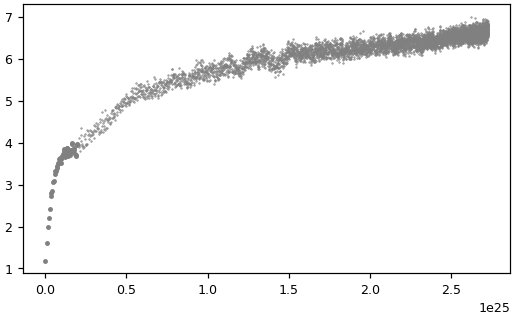

In [ ]:
break

$\lambda$ = 1.28 W/m$^2$/K        ECS = 3.28 degC
$\lambda$_20 = 1.11 W/m$^2$/K     ECS_20 = 3.47 degC

$\lambda$ = 1.43 W/m$^2$/K        ECS = 3.14 degC
$\lambda$_20 = 1.68 W/m$^2$/K     ECS_20 = 3.03 degC

$\lambda$ = 1.20 W/m$^2$/K        ECS = 3.42 degC
$\lambda$_20 = 1.15 W/m$^2$/K     ECS_20 = 3.47 degC



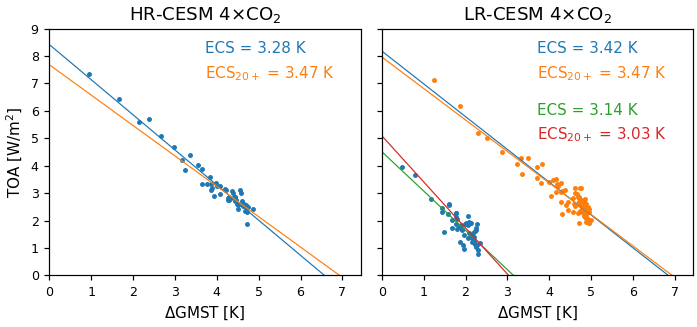

In [14]:
lam, Delta, sq, p20 = r'$\lambda$', r'$\Delta$', r'$^2$', r'$_{20+}$'
f, ax = plt.subplots(1, 2, figsize=(6.4,3), sharey=True, constrained_layout=True)
ax[0].set_title(r'HR-CESM 4$\times$CO$_2$')
ax[0].set_xlabel(f'{Delta}GMST [K]')
ax[0].set_ylabel(f'TOA [W/m{sq}]')
ax[1].set_title(r'LR-CESM 4$\times$CO$_2$')
ax[1].set_xlabel(f'{Delta}GMST [K]')
for i in range(3):
    axs = [ax[0], ax[1], ax[1]][i]
    (c1,c2) = [('C0','C1'),('C2','C3'),('C0','C1')][i]
    GMST = [gmst_hq, gmst_ld, gmst_lq][i].rolling(time=12).mean()[11::12]-[GMST_h200, GMST_l500, GMST_l1200][i]
    TOA = [FTNT_hq, FTNT_ld, FTNT_lq][i]/A_Earth
    axs.axhline(0, c='k', lw=.5)
    axs.scatter(GMST, TOA, s=5)
    m, b = np.polyfit(GMST, TOA, 1)
    axs.plot([0, -b/m], [b,0], c=c1, lw=.8)
#     axs.text(.2,.9, f'{lam} = {-m:3.2f} W/m{sq}/K', transform=axs.transAxes, c=c1)
    axs.text(.5,[.8,.55,.8][i]+.1, f'ECS = {-b/m/[2,1,2][i]:3.2f} K', transform=axs.transAxes, c=c1)
    print(f'{lam} = {-m:3.2f} W/m{sq}/K        ECS = {-b/m/[2,1,2][i]:3.2f} degC')
    
    m, b = np.polyfit(GMST[20:], TOA[20:], 1)
    axs.plot([0, -b/m], [b,0], c=c2, lw=.8)
#     axs.text(0.05,.25, f'only year 20+', transform=axs.transAxes, c=c2)
#     axs.text(0.05,.15, f'{lam} = {-m:3.2f} W/m{sq}/K', transform=axs.transAxes, c=c2)
    axs.text(0.5,[.7,.45,.7][i]+.1, f'ECS{p20} = {-b/m/[2,1,2][i]:3.2f} K', transform=axs.transAxes, c=c2)
    print(f'{lam}_20 = {-m:3.2f} W/m{sq}/K     ECS_20 = {-b/m/[2,1,2][i]:3.2f} degC')
    print('')
    axs.set_xlim((0,-b/m+.5))
    axs.set_ylim((0,9))
    plt.savefig(f'{path_results}/ECS/Gregory_plots')
    plt.savefig(f'{path_results}/thesis/62_Gregory_plots.eps')

In [12]:
# print(GMST_h200.values, GMST_l1200.values)
# print(hqm['T'] .values, lqm['T']  .values)
# print(hqm['N'] .values, lqm['N']  .values)


287.9406842348562 288.4687842140057
288.92918524321425 289.46328472598947
0.20668308617269074 0.16512576995333045


In [13]:
# transient climate sensitivity around year 2078
print((gmst_rcp.isel(time=slice(12*67,12*87)).mean('time')-GMST_h200).values)
print((gmst_lr1.isel(time=slice(12*67,12*87)).mean('time')-GMST_l500).values)


2.0594551140521844
2.033315721833219


../longrunmip_estimations.py:416: RankWarning: Polyfit may be poorly conditioned
  G = estimationGregory(DT,DR)
../longrunmip_estimations.py:421: RankWarning: Polyfit may be poorly conditioned
  G20 = estimationGregory20(DT,DR)
../longrunmip_estimations.py:97: RuntimeWarning: invalid value encountered in double_scalars
  x_switch = - (f2-f1)/(l2-l1)
../longrunmip_estimations.py:98: RuntimeWarning: invalid value encountered in less
  y = (f1 + l1 * x) * (x < x_switch) + (f2 + l2 * x) * (x >= x_switch)
../longrunmip_estimations.py:98: RuntimeWarning: invalid value encountered in greater_equal
  y = (f1 + l1 * x) * (x < x_switch) + (f2 + l2 * x) * (x >= x_switch)
../longrunmip_estimations.py:97: RuntimeWarning: divide by zero encountered in double_scalars
  x_switch = - (f2-f1)/(l2-l1)
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
../longrunmip_esti

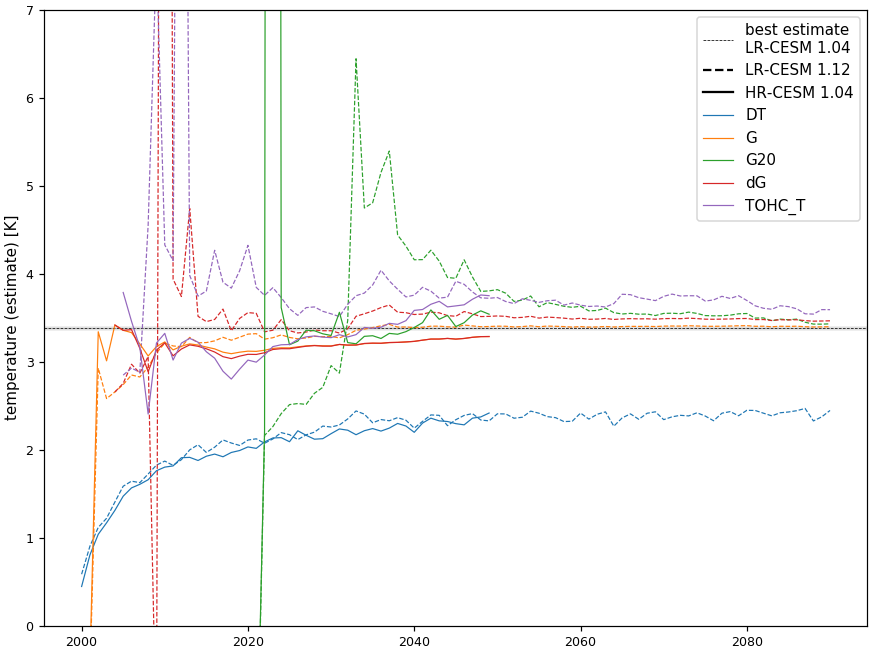

In [17]:
plt.figure(figsize=(8,6))
plt.axhspan(6.73/2,6.8/2, color='lightgrey', alpha=.5)
plt.axhline(6.76/2, c='k', lw=.5, ls='--', label='best estimate\nLR-CESM 1.04')

for i, run in enumerate(['lq','hq']):
    plt.plot([],[],ls=['--','-'][i], c='k', label=['LR-CESM 1.12','HR-CESM 1.04'][i])
    ds    = [lqa, hqa][i]
    dm    = [lqm, hqm][i]
    DT    = (ds['T']-[GMST_l1200,GMST_h200][i]).values
    DT    = (ds['T']-dm['T']).values
    DR    = (ds['N']).values # -dm['N']
    DOHC  = [OHC_lq.OHC_Global_Ocean.values, OHC_hq2][i]
    DALB  = (ds['a']-dm['a']).values
    DEMM  = (ds['e']-dm['e']).values*sigma
    DALBd = np.gradient(ds['a'])
    DEMMd = np.gradient(ds['e']*sigma)
    DOHCd = np.gradient([OHC_lq.OHC_Global_Ocean, OHC_hq2][i])
    ests, ds  = do_estimations(DT, DALB, DEMM, DR, DALBd, DEMMd, DOHC, DOHCd, name=run)
#     for j, q in enumerate(['DT', 'G', 'G20', 'dG', 'Ta_T', 'Te_T', 'Tae_T', 'TOHC_T']):
    for j, q in enumerate(['DT', 'G', 'G20', 'dG', 'TOHC_T']):
        plt.plot(ds.time+2000, ds[q]/2, ls=['--','-'][i], lw=.8, c=f'C{j}', label=[None,q][i])
plt.ylim((0,7))
plt.ylabel(('temperature (estimate) [K]'))
plt.legend()    

$\lambda$ = 1.27 W/m$^2$/K        ECS = 3.29 degC
$\lambda$_20 = 1.07 W/m$^2$/K     ECS_20 = 3.51 degC

$\lambda$ = 1.19 W/m$^2$/K        ECS = 6.80 degC
$\lambda$_20 = 1.15 W/m$^2$/K     ECS_20 = 3.44 degC



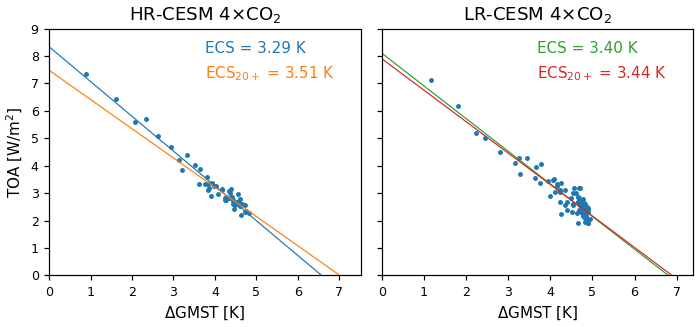

In [26]:
lam, Delta, sq, p20 = r'$\lambda$', r'$\Delta$', r'$^2$', r'$_{20+}$'
f, ax = plt.subplots(1, 2, figsize=(6.4,3), sharey=True, constrained_layout=True)
ax[0].set_title(r'HR-CESM 4$\times$CO$_2$')
ax[0].set_xlabel(f'{Delta}GMST [K]')
ax[0].set_ylabel(f'TOA [W/m{sq}]')
ax[1].set_title(r'LR-CESM 4$\times$CO$_2$')
ax[1].set_xlabel(f'{Delta}GMST [K]')
for i in range(2):
    axs = [ax[0], ax[1], ax[1]][i]
    (c1,c2) = [('C0','C1'),('C2','C3'),('C0','C1')][i]
    GMST = [hqa['T'], lqa['T']][i]-[hqm['T'], lqm['T']][i]
    TOA = [hqa['N'], lqa['N']][i]
    axs.axhline(0, c='k', lw=.5)
    axs.scatter(GMST, TOA, s=5)
    m, b = np.polyfit(GMST, TOA, 1)
    axs.plot([0, -b/m], [b,0], c=c1, lw=.8)
    axs.text(.5,[.8,.8][i]+.1, f'ECS = {-b/m/[2,2][i]:3.2f} K', transform=axs.transAxes, c=c1)
    print(f'{lam} = {-m:3.2f} W/m{sq}/K        ECS = {-b/m/[2,1,2][i]:3.2f} degC')
    
    m, b = np.polyfit(GMST[20:], TOA[20:], 1)
    axs.plot([0, -b/m], [b,0], c=c2, lw=.8)
    axs.text(0.5,[.7,.7][i]+.1, f'ECS{p20} = {-b/m/[2,2][i]:3.2f} K', transform=axs.transAxes, c=c2)
    print(f'{lam}_20 = {-m:3.2f} W/m{sq}/K     ECS_20 = {-b/m/2:3.2f} degC')
    print('')
    axs.set_xlim((0,-b/m+.5))
    axs.set_ylim((0,9))
#     plt.savefig(f'{path_results}/ECS/Gregory_plots')
#     plt.savefig(f'{path_results}/thesis/62_Gregory_plots.eps')

Text(0, 0.5, '$\\Delta$OHC [J]')

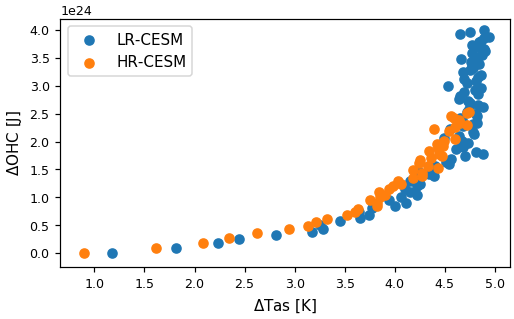

In [18]:
for i, run in enumerate(['lq','hq']):
    OHC = [OHC_lq, OHC_hq][i]
    ds    = [lqa, hqa.isel(time=slice(0,-1))][i]
    dm    = [lqm, hqm     ][i]
    plt.scatter(ds['T']-dm['T'], OHC.OHC_Global_Ocean-OHC.OHC_Global_Ocean[0], label=['LR-CESM','HR-CESM'][i])
plt.legend()
plt.xlabel(r'$\Delta$Tas [K]')
plt.ylabel(r'$\Delta$OHC [J]')

## Data generation

In [ ]:
# %%time
# # combining GMST, TOA, albedo, emissivity for Robbin's plots
# dxdy = ['lat','lon']
# for j, run in enumerate(['ctrl','lpd']):  # ('hq','lq')
#     (ys, ye) = [(200,230),(1170,1200)][j]
#     datasets = []
#     k = 0
#     for i, (y,m,fn) in tqdm(enumerate(IterateOutputCESM(domain='atm',run=run,tavg='monthly'))):
#         if y<ys:  continue
#         if y>ye:  continue
#         ds = xr.open_dataset(fn, decode_times=False)
#         if k==0:  weight = np.cos(np.deg2rad(ds.lat))
#         D = xr.Dataset(data_vars=dict(T=(['time'], ds.TS.weighted(weight).mean(dxdy)),
#                                       N=(['time'], (ds.FSNT-ds.FLNT).weighted(weight).mean(dxdy)),
#                                       a=(['time'], (ds.FSUTOA/(ds.FSNTOA+ds.FSUTOA)).weighted(weight).mean(dxdy)),
#                                       e=(['time'], (ds.FLUT/ds.TS**4).weighted(weight).mean(dxdy)/sigma),
#                                      ),
#                        coords={'time':ds.time}
#                       )
#         datasets.append(D)
#         k+=1
#     combined = xr.concat(datasets, dim='time')
#     combined.to_netcdf(f'{path_results}/ECS/ECS_Robbin_monthly_{run}.nc')

(0, 50)

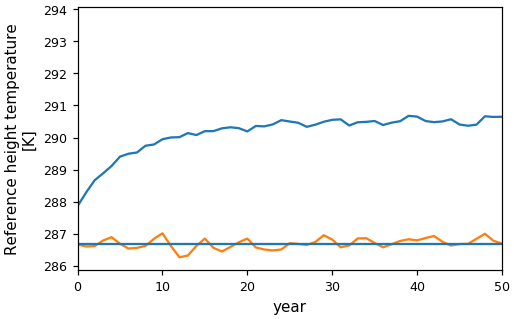

In [22]:
xr.open_dataarray('../../data/LongRunMIP/tas_CESM104_abrupt4x_5900.nc').plot()
xr.open_dataarray('../../data/LongRunMIP/tas_CESM104_control_1000.nc').plot()
plt.axhline(xr.open_dataarray('../../data/LongRunMIP/tas_CESM104_control_1000.nc').mean())

plt.xlim((0,50))

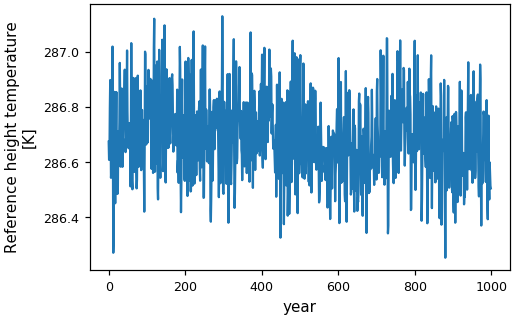

In [21]:
# plt.xlim((0,50))

In [4]:
%%time
for i, sim in enumerate(['HR-CESM','LR-CESM','LongRunMIP']):
    Nt = [50,91,5900][i]
    ds = xr.Dataset(coords={'time':np.arange(Nt)})
    if sim in ['HR-CESM','LR-CESM']:
#         continue
        (quad, ctl)  = [('hq','ctrl'), ('lq','lpd')][i]
        q_monthly = xr.open_dataset(f'{path_results}/ECS/ECS_Robbin_monthly_{quad}.nc', decode_times=False)
        q_annual  = q_monthly.rolling(time=12).mean().isel(time=slice(11,None,12))
        q_mean = xr.open_dataset(f'{path_results}/ECS/ECS_Robbin_monthly_{ctl}.nc', decode_times=False).mean('time')
        print(q_mean['N'])
        ohc = xr.open_dataset(f'{path_prace}/OHC/OHC_integrals_{quad}.nc', decode_times=False).OHC_Global_Ocean.values
        if sim=='HR-CESM':
            ohc = ohc[np.delete(np.arange(0,50), 39)]
            ohc = np.concatenate([ohc[:39], [(2*ohc[38]+ohc[39])/3], [(ohc[38]+2*ohc[39])/3], ohc[39:48]]).flatten()
            
        print('test')
        N = (['time'],  q_annual['N'].values               )
        print('test')
        T = (['time'], (q_annual['T'] - q_mean['T']).values)
        print('test')
        a = (['time'], (q_annual['a'] - q_mean['a']).values)
        print('test')
        e = (['time'], (q_annual['e'] - q_mean['e']).values)

    elif sim in ['LongRunMIP']:
        tas  = xr.open_dataarray('../../data/LongRunMIP/tas_CESM104_abrupt4x_5900.nc') .rename({'year':'time'})
        rsdt = xr.open_dataarray('../../data/LongRunMIP/rsdt_CESM104_abrupt4x_5900.nc').rename({'year':'time'})
        rsut = xr.open_dataarray('../../data/LongRunMIP/rsut_CESM104_abrupt4x_5900.nc').rename({'year':'time'})
        rlut = xr.open_dataarray('../../data/LongRunMIP/rlut_CESM104_abrupt4x_5900.nc').rename({'year':'time'})
        tasc  = xr.open_dataarray('../../data/LongRunMIP/tas_CESM104_control_1000.nc' ).mean('year')
        rsdtc = xr.open_dataarray('../../data/LongRunMIP/rsdt_CESM104_control_1000.nc').mean('year')
        rsutc = xr.open_dataarray('../../data/LongRunMIP/rsut_CESM104_control_1000.nc').mean('year')
        rlutc = xr.open_dataarray('../../data/LongRunMIP/rlut_CESM104_control_1000.nc').mean('year')
        ohc_lrm = xr.open_dataarray(f'../../data/LongRunMIP/OHC_4xCO2.nc')
        #       print((rsdtc-rsutc-rlutc).isel(time=slice(0,Nt)).mean('time').values)
        T = (['time'], (tas -tasc).values)
        N = (['time'], (rsdt-rsut-rlut).values)
        a = (['time'], (rsut/rlut - rsutc/rlutc).values)
        e = (['time'], (rlut/tas**4/sigma - rlutc/tasc**4/sigma).values)
        ohc = (['time'], ohc_lrm.values)
        
    ds['T'] = T
    ds['N'] = N
    ds['a'] = a
    ds['e'] = e
    ds['OHC'] = ohc
    do_estimations(ds).to_netcdf(f'../../results/ECS/ECS_estimates_{sim}.nc')

../longrunmip_estimations.py:417: RankWarning: Polyfit may be poorly conditioned
  G = estimationGregory(DT,DR)
../longrunmip_estimations.py:422: RankWarning: Polyfit may be poorly conditioned
  G20 = estimationGregory20(DT,DR)
../longrunmip_estimations.py:97: RuntimeWarning: invalid value encountered in double_scalars
  x_switch = - (f2-f1)/(l2-l1)
../longrunmip_estimations.py:97: RuntimeWarning: divide by zero encountered in double_scalars
  x_switch = - (f2-f1)/(l2-l1)
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


CPU times: user 3min 39s, sys: 264 ms, total: 3min 39s
Wall time: 3min 39s


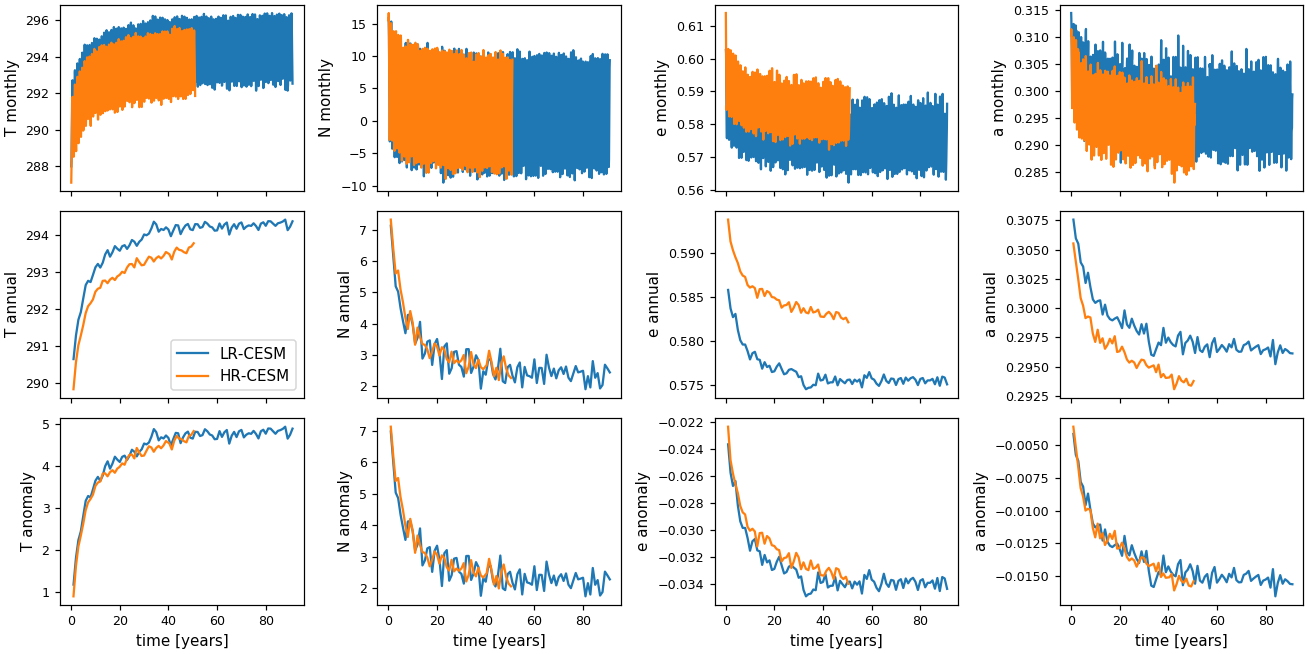

In [11]:
f, ax = plt.subplots(3,4, figsize=(12,6), sharex=True)
for i, q in enumerate(['T','N','e','a']):
    ax[0,i].plot(lq.time/365, lq[q])
    ax[0,i].plot(hq.time/365, hq[q])
    ax[1,i].plot(lqa.time/365, lqa[q], label='LR-CESM')
    ax[1,i].plot(hqa.time/365, hqa[q], label='HR-CESM')
    ax[2,i].plot(lqa.time/365, lqa[q]-lqm[q])
    ax[2,i].plot(hqa.time/365, hqa[q]-hqm[q])
    for j in range(3):
        ax[j,i].set_ylabel(q+' '+['monthly','annual','anomaly'][j])
    ax[-1,i].set_xlabel('time [years]')
ax[1,0].legend()
# f.align_ylabels()

In [ ]:
# # originally used these data
# # made in GMST.ipynb
# gmst_ctrl = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_ctrl.nc', decode_times=False)
# gmst_rcp  = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_rcp.nc' , decode_times=False)
# gmst_hq   = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_hq.nc'  , decode_times=False)
# gmst_lpd  = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_lpd.nc' , decode_times=False)
# gmst_lr1  = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_lr1.nc' , decode_times=False)
# gmst_lq   = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_lq.nc'  , decode_times=False)
# gmst_ld   = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_ld.nc'  , decode_times=False)
# GMST_h200  = gmst_ctrl.sel(time=slice(200*365,230*365)).mean()
# GMST_l500  = gmst_lpd.isel(time=slice(0,30*12)).mean()
# GMST_l1200 = gmst_lpd.isel(time=slice(690*12,720*12)).mean()
# # from `TOA.ipynb`
# FTNT_rcp  = xr.open_dataarray(f'{path_prace}/TOA/TOM_rcp.nc', decode_times=False)
# FTNT_lr1  = xr.open_dataarray(f'{path_prace}/TOA/TOM_lr1.nc', decode_times=False)
# FTNT_hq   = xr.open_dataarray(f'{path_prace}/TOA/TOM_hq.nc' , decode_times=False)
# FTNT_lq   = xr.open_dataarray(f'{path_prace}/TOA/TOM_lq.nc' , decode_times=False)
# FTNT_ld   = xr.open_dataarray(f'{path_prace}/TOA/TOM_ld.nc' , decode_times=False)

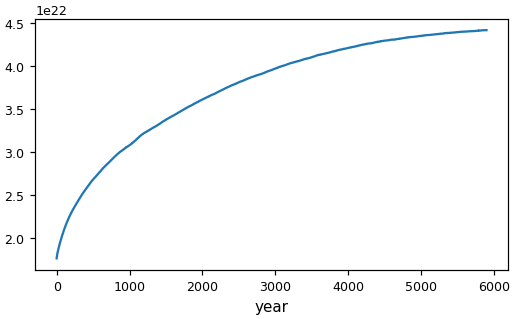

In [4]:
ohc_lrm = xr.open_dataarray(f'../../data/LongRunMIP/OHC_4xCO2.nc')
ohc_lrm.plot()